<a href="https://colab.research.google.com/github/326-YL/403-Fall-2022/blob/main/Copy_of_hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 7 Cart-pole Dynamics Simulation**

The goal of HW 7 is to create a dynamics simulation of a cart-pole system described in the figure below. 

<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw7/cart-pole.png?raw=true" width="450">

Use a generalized coordinate given in the figure. We give forward kinematics of important places of the system. 

\begin{align}
rA= \begin{pmatrix}
    x \\
    0 \\
    0
     \end{pmatrix},  &
\ rB = \begin{pmatrix}
    x + ccos(\theta)  \\
    csin(\theta) \\
    \theta
     \end{pmatrix} 
\\[10pt]
\implies vA= \begin{pmatrix}
    \dot{x} \\
    0 \\
    0
     \end{pmatrix}, &
\ vB = \begin{pmatrix}
    \dot{x} -c\dot{\theta}sin(\theta)  \\
    c\dot{\theta}cos(\theta) \\
    \dot{\theta}
     \end{pmatrix}
\\[10pt]
\implies aA= \begin{pmatrix}
    \ddot{x} \\
    0 \\
    0
     \end{pmatrix}, &
\ aB = \begin{pmatrix}
    \ddot{x} -c\ddot{\theta}sin(\theta)-c\dot{\theta}^2cos(\theta)  \\
    c\ddot{\theta}cos(\theta) - c\dot{\theta}^2sin(\theta) \\
    \ddot{\theta}
     \end{pmatrix}
\\[10pt]
\end{align}

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import math 
import time 
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

# **Q.1 Dynamics of a cart-pole system**

To make a dynamics simulation, we first need to complete the formula: 

$M \ddot{q} + b (q, \dot{q}) + g(q) = \begin{pmatrix} f \\ \tau \end{pmatrix} $.

Identify $M$, $b$, and $g$. Similar systems are used in the lecture and practice set. Please refer those. 


# Q.1.(a) [20 pts] Dynamics function 
Based on the given template code, complete the function returning the acceleration of the generalized coordinate: 

$\ddot{q} = \begin{pmatrix}
\ddot{x} \\ \ddot{\theta}
\end{pmatrix} = M^{-1}\left( u - b -g \right)$ 


In [ ]:
def dynamics(q, u, params):
  m1, m2, I2, c, g = params
  x, th, xdot, thdot  = q.tolist()
  #print(th)
  #print(q[1])
  
  # Fill your code: define b (coriolis and centripetal), g (gravitational force), and M (mass matrix)
  b =np.array([-m2*c*thdot*thdot*np.cos(th),0]).T
  g =np.array([0,m2*g*c*np.cos(th)]).T
  M =np.array([[m1+m2,-m2*c*np.sin(th)],[-m2*c*np.sin(th),I2+m2*c*c]])
  qddot =np.linalg.inv(M)@(u-b-g)
  #print(f"qddot:{qddot}")
  return qddot

In [ ]:
# Test function: No need to change
def test_dynamics():
  m1 = 0.5
  m2 = 0.5
  I2 = 1
  c = 0.2
  g = 9.81
  dt = 0.005
  tf = 10.0
  params = [m1, m2, I2, c, g]
  test_cases = np.array([[0.0, np.pi/4, 0.0, 0.0],
                [0.5, -np.pi/4, 0.0, 0.0],
                [0.0, 0, 0.5, 0.0],
                [0.0, 0, 0.0, 5],
                ])
  soln = np.array([[-0.04832512, -0.68342045],
                   [ 0.04832512, -0.68342045],
                   [ 0.,         -0.96176471],
                   [ 2.5,        -0.96176471]])
  u = np.array([0, 0])
  res = np.zeros((4, 2))
  for i, q in enumerate(test_cases):
    #print(q)
    res[i, :] = dynamics(q, u, params)
  assert np.allclose(res, soln), f"your dynamics implementation is not correct: your result {res} != solution: \n {soln}"
  print('Your implementation is correct!!')

In [ ]:
test_dynamics()

Your implementation is correct!!


# Q 1.1.(b) [15 pts] Dynamics simulation 

Complete the following function that finds state trajectory by using dynamics function we found in Q.1.1.(a). 

In [ ]:
def simulate_cartpole(x0, params, tf=1.0, dt=0.01):
  m1, m2, I2, c, g = params
  num_step = int(np.floor(tf/dt));
  tspan = np.linspace(0, tf, num_step); 
  x_out = np.zeros((4,num_step));
  #print(f"x_out:{x_out}")
  x_out[:,0] = x0;

  for i in range(num_step-1):
      u = np.zeros(2).T # put zero since there is no motor input for Q.1.

      # Fill your code: update the sequence of state (x_out) by utilizing the dynamcs function
      # Hint: use semi-implicit Euler integration
      #q=q+q_dot*dt

      q_ddot=dynamics(x_out[:,i],u,params)
      x_ddot=q_ddot[0]
      x_dot=x_out[:,i][2]+x_ddot*dt
      x=x_out[:,i][0]+x_dot*dt

      th_ddot=q_ddot[1]
      th_dot=x_out[:,i][3]+th_ddot*dt
      th=x_out[:,i][1]+th_dot*dt

      # [x,th,xdot,thdot]
      q_out=np.array([x,th,x_dot,th_dot]).T
      x_out[:,i+1]=q_out



    
  return x_out

In [ ]:
# Use the given parameters: No need to change
m1 = 0.5
m2 = 0.5
I2 = 1
c = 0.2
g = 9.81
dt = 0.005
tf = 10.0
params = [m1, m2, I2, c, g]



In [ ]:
# Cart-Pole visualization function: No need to change
def visualize_cartpole(q_hist, params=[0.4, 0.4, 0.01], num_frames=100):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)   
  c_l, p_l, dt = params
  cart, = ax.plot([-0.5*c_l, 0.5*c_l], [0, 0], 'b', lw=10)
  pole, = ax.plot([0, 0], [0, p_l], 'r', lw=10)
  
  txt_title = ax.set_title('')
  
  ax.set_xlim(( -1, 1))            
  ax.set_ylim((-0.7, 1.3))
  txt_title = ax.set_title('')
  interval = len(q_hist)//num_frames
  def drawFrame(k):
    k = interval*k
    x, theta = q_hist[k]

    rA = [x, 0]
    rC = [x + p_l*np.cos(theta), p_l*np.sin(theta)]
    cart.set_data([x-0.5*c_l, x+0.5*c_l], [0, 0])
    pole.set_data([rA[0], rC[0]], [rA[1], rC[1]])
    txt_title.set_text(f't = {dt*k:.2f} sec')
    return cart, pole
  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim


In [ ]:
# Simulation and animation code: No need to change
x0 = np.array([0.0, np.pi/4, 0.0, 0.0]).T;
x_out = simulate_cartpole(x0, params, tf=tf, dt=dt)
anim = visualize_cartpole(x_out[:2, :].T, num_frames=50)
plt.close()
HTML(anim.to_html5_video())

# Q.1.(c) [15 pts] Kinetic and Potential Energy

Plot the kinetic, potential, and total energy of the system. 

Hint: use the equation, $T = \frac{1}{2} \dot{q}^{\top}M\dot{q}$, for kinetic energy computation.

In [30]:
from pyparsing.helpers import quoted_string
def kinetic_energy(q, params):
  m1, m2, I2, c, g = params


  # Fill your code: complete the function return the profile of kinetic energy
  x, th, xdot, thdot  = q.tolist()
  #get M
  M =np.array([[m1+m2,-m2*c*np.sin(th)],[-m2*c*np.sin(th),I2+m2*c*c]])
  #get q_dot
  q_dot=np.array([xdot,thdot]).T

  T =1/2*q_dot.T@M@q_dot

  return T

def potential_energy(q, params):
  m1, m2, I2, c, g = params

  # Fill your code: complete the function return the profile of kinetic energy
  x, th, xdot, thdot  = q.tolist()
  #get h first-->rb * (-g^). (-g^)=(0,1,0)
  h=np.array([x+c*np.cos(th),c*np.sin(th),th])@np.array([0,1,0]).T

  P=m2*g*h
  return P

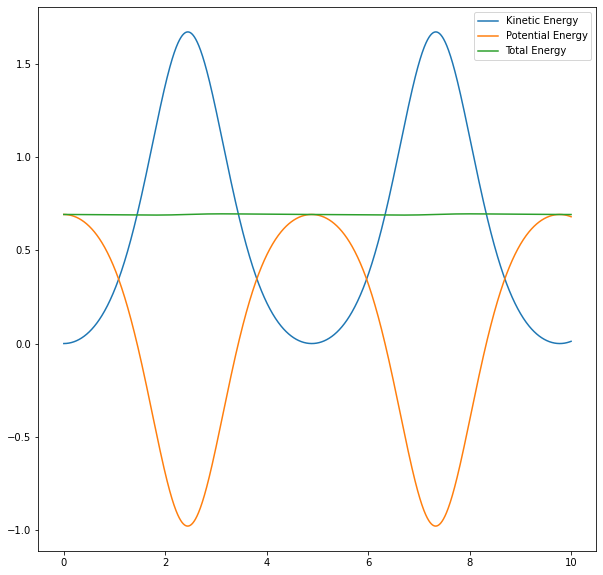

In [31]:
# Kinematic, potential, and total energy plot: No need to change
ke_hist = np.zeros(x_out.shape[1])
pe_hist = np.zeros(x_out.shape[1])
ts = np.arange(0, tf, dt)

for i, x in enumerate(x_out.T):
  ke_hist[i] = kinetic_energy(x, params)
  pe_hist[i] = potential_energy(x, params)

fig= plt.figure(figsize=(10,10))
plt.plot(ts, ke_hist, label='Kinetic Energy')
plt.plot(ts, pe_hist, label='Potential Energy')
plt.plot(ts, pe_hist+ke_hist, label='Total Energy')
plt.legend()
plt.show()

# Q.1.(d) [10 pts] Energy profile analysis

Explain the meaning of energy profiles by correlating them with the system's behavior.


Your answer: 
when the change of the Kinetic energy increases 
alomost equal to the change of the potential energy decrease, 
the total energy nearly remain constant, but the 
total energy line is not a traight line, since the 
semi-implicit Euler integration can not guarantee the
 100% energy conservation

# **Q.2. The effect of damping** 

Now, let's consider the case when actuators operate like dampers. The first prismatic joint resists the joint motion with viscous friction efficiency of 0.5. Therefore, the formulation will be $f = -0.5\  \dot{x}$. For the second revolute joint, we will make the same viscous friction but with a coefficient of 10. Therefore, the formula is $\tau = -10\  \dot{\theta}$.  


# Q.2.(a) [15 pts] Dynamics simulation of the cart-pole with the dampers.

Complete the dynamics simulation code of the cart-pole system with the dampings explained above. 

In [ ]:
def simulate_cartpole_damping(x0, params, tf=1.0, dt=0.01):
  m1, m2, I2, c, g = params
  num_step = int(np.floor(tf/dt));
  tspan = np.linspace(0, tf, num_step); 
  x_out = np.zeros((4,num_step));
  x_out[:,0] = x0;

  for i in range(num_step-1):
      # Fill your code: define the proper force and torque input 
      u =np.array([-0.5*x_out[:,i][2],-10*x_out[:,i][3]]).T


      # Fill your code: update the sequence of state (x_out) by utilizing the dynamcs function
      # Hint: use semi-implicit Euler integration
      q_ddot=dynamics(x_out[:,i],u,params)
      x_ddot=q_ddot[0]
      x_dot=x_out[:,i][2]+x_ddot*dt
      x=x_out[:,i][0]+x_dot*dt

      th_ddot=q_ddot[1]
      th_dot=x_out[:,i][3]+th_ddot*dt
      th=x_out[:,i][1]+th_dot*dt

      # [x,th,xdot,thdot]
      q_out=np.array([x,th,x_dot,th_dot]).T
      x_out[:,i+1]=q_out
  
  return x_out

In [ ]:
x0 = np.array([0.0, np.pi/4, 0.0, 0.0]).T;
x_out_damped = simulate_cartpole_damping(x0, params, tf=tf, dt=dt)
anim = visualize_cartpole(x_out_damped[:2, :].T, num_frames=50)
plt.close()
HTML(anim.to_html5_video())

# Q.2.(b) [15 pts] Energy plot

Plot the kinetic, potential, and total energy of system by refering the codes in Q.1.(c). 

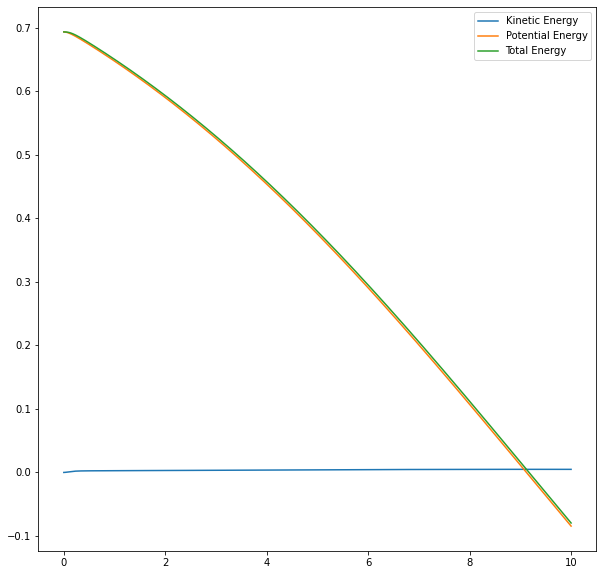

In [ ]:
ke_hist = np.zeros(x_out_damped.shape[1])
pe_hist = np.zeros(x_out_damped.shape[1])
ts = np.arange(0, tf, dt)

# Fill our your code: 
for i, x in enumerate(x_out_damped.T):
  ke_hist[i] = kinetic_energy(x, params)
  pe_hist[i] = potential_energy(x, params)

fig= plt.figure(figsize=(10,10))
plt.plot(ts, ke_hist, label='Kinetic Energy')
plt.plot(ts, pe_hist, label='Potential Energy')
plt.plot(ts, pe_hist+ke_hist, label='Total Energy')
plt.legend()
plt.show()

# Q.2.(c) [10 pts] Energy profile analysis

Explain the meaning of energy profiles by correlating them with the system's behavior and the previous non-damping case.


Your answer: the kinetic energy nearly remains zero, only
the Potential energy in the whole system, total energy
is the sum of kinetic energy and potential energy, since kinetic energy equal
to zero, so the change of total energy will be euqal to the change of potential 
energy, to make dumping system, we multiply negative coefficient to force and turque with semi-implicit Euler integration, due to wind resistance,the system is losing the energy.